DATA LOADING AND SPLITTING

In [1]:
import sys
import os
import warnings

warnings.simplefilter("ignore")

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'proposal')))

from data_distribution.data_loading import *

X,y=load_data("../data/survey_lung_cancer_small.csv")
X, label_encod=preprocess_data_label_encoding(X)
X_train, X_test, y_train, y_test = data_split(X, y,test_size=0.2, random_state=45)

SIMPLE MODEL

Starting training...
Model successfully trained.
Evaluation results:
              precision    recall  f1-score   support

          NO       0.80      0.50      0.62         8
         YES       0.93      0.98      0.96        55

    accuracy                           0.92        63
   macro avg       0.87      0.74      0.79        63
weighted avg       0.91      0.92      0.91        63

Test set accuracy: 0.92


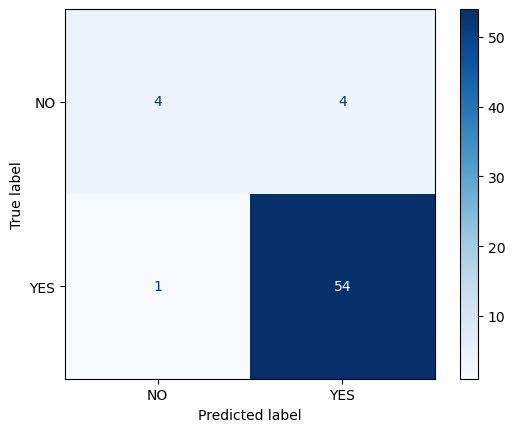

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import os

# Add the project path to the import list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'proposal')))

from models.random_forest import *

# Initialize and train the Random Forest model
rf_model = RandomForestModel(n_estimators=50, max_depth=None, random_state=45)
rf_model.train(X_train, y_train)

from sklearn.metrics import classification_report, balanced_accuracy_score

# Evaluate the model on the test set
y_test_pred = rf_model.predict(X_test)
accuracy_val = rf_model.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

SMOTE


Starting training...
Model successfully trained.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

          NO       0.71      0.62      0.67         8
         YES       0.95      0.96      0.95        55

    accuracy                           0.92        63
   macro avg       0.83      0.79      0.81        63
weighted avg       0.92      0.92      0.92        63

Test set accuracy: 0.92


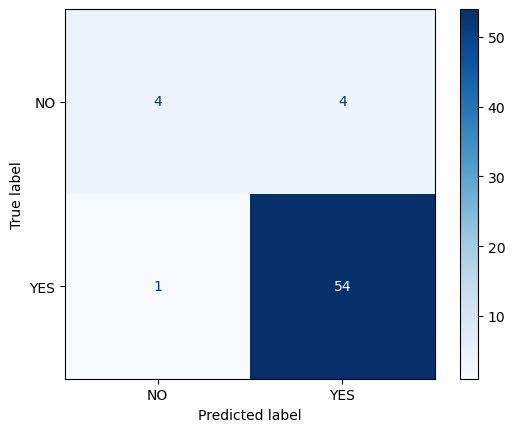

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Apply SMOTE to the training set to handle class imbalance
smote = SMOTE(random_state=45)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the Random Forest model using the balanced dataset
rf_model.train(X_train_resampled, y_train_resampled)

# Evaluate the Random Forest model
print("\nEvaluation on the test set:")
accuracy_val = rf_model.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

CROSS-VALIDATION


Starting hyperparameter tuning...
Fitting 10 folds for each of 288 candidates, totalling 2880 fits

Best parameters found:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}

Best average accuracy during cross-validation:
0.9609936575052854
Training the optimized model...
Starting training...
Model successfully trained.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

          NO       0.71      0.62      0.67         8
         YES       0.95      0.96      0.95        55

    accuracy                           0.92        63
   macro avg       0.83      0.79      0.81        63
weighted avg       0.92      0.92      0.92        63

Test set accuracy: 0.92


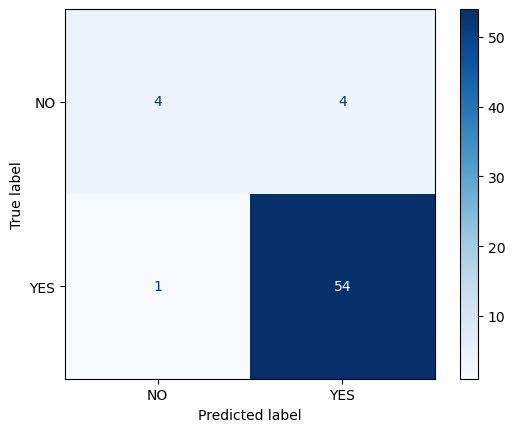

In [4]:
# Import GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],    # Maximum depth
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required at a leaf node
    'bootstrap': [True, False]          # Sampling with or without replacement
}

# Initialize GridSearchCV with Random Forest
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=45), 
    param_grid=param_grid, 
    scoring='accuracy',  # Metric to optimize
    cv=10,               # Number of folds for cross-validation
    n_jobs=-1,           # Run in parallel
    verbose=2            # Log the process
)

# Train the model using GridSearchCV
print("\nStarting hyperparameter tuning...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Display the best hyperparameter results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest average accuracy during cross-validation:")
print(grid_search.best_score_)

# Retrieve the best model from GridSearchCV
best_model = grid_search.best_estimator_
# Get the best hyperparameters from the best model
best_params = best_model.get_params()

# Create an instance of RandomForestModel using the optimized parameters
rf_model_optimized = RandomForestModel(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=best_params['random_state'],
    class_weight=best_params['class_weight']
)

# Train the optimized model
print("Training the optimized model...")
rf_model_optimized.train(X_train_resampled, y_train_resampled)

# Evaluate the optimized model on the test set
print("\nEvaluation on the test set:")
accuracy_val = rf_model_optimized.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Feature Engineering: Create new interaction features
X['Age*Smoking'] = X['AGE'] * X['SMOKING']
X['Chronic*Anxiety'] = X['CHRONIC DISEASE'] * X['ANXIETY']
print("Added interaction features to the dataset.")

# Split the dataset into training and testing sets after adding new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Standardize the data after adding the new features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an updated Random Forest model
rf_model_optimized = RandomForestModel(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=best_params['random_state'],
    class_weight=best_params['class_weight']
)
# Train the optimized model
print("Training the optimized model...")
rf_model_optimized.train(X_train_scaled, y_train)

# Evaluate the Random Forest model.
print("\nEvaluation on the test set:")
accuracy_val = rf_model_optimized.evaluate(X_test_scaled, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

Added interaction features to the dataset.
Training the optimized model...
Starting training...
Model successfully trained.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

          NO       0.67      0.50      0.57         8
         YES       0.93      0.96      0.95        55

    accuracy                           0.90        63
   macro avg       0.80      0.73      0.76        63
weighted avg       0.90      0.90      0.90        63

Test set accuracy: 0.90


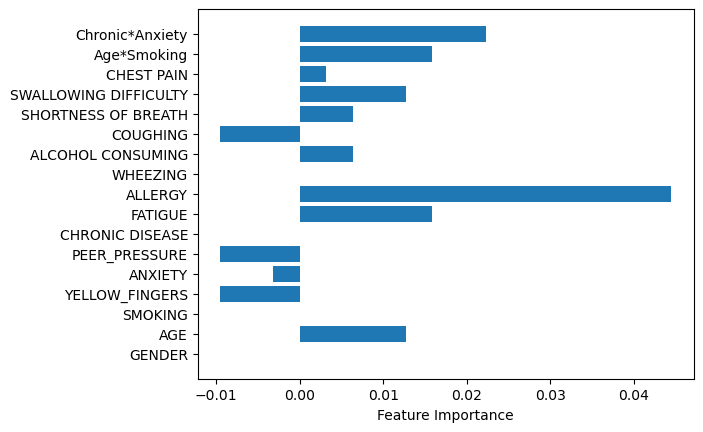

In [6]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance for the model
result = permutation_importance(rf_model_optimized.model, X_test_scaled, y_test, scoring="accuracy")
feature_importance = result.importances_mean

# Visualize the most important features
plt.barh(range(len(feature_importance)), feature_importance)
plt.yticks(range(len(feature_importance)), X.columns)
plt.xlabel("Feature Importance")
plt.show()